# Creating network topology with pysheds
## This code illustrated how to make a watershed or basin for a given point in a river, also assist with network topology of the river (which river segment drain into which river).


In [1]:
# import necessary packages
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoSeries
# set the font and font size
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})

## Getting the data from the river network from Example_1
### The end point of each river segment identified here act like a virtual gauges for creating the sub-basins

In [14]:
path = '/Users/shg096/Desktop/Network_topology_example/' # identifying the path to the folder that the conditioned DEM is location
# load the shapefile form the last example
A = gpd.read_file(path+'river_network_100000.shp') # shapefile from example 1


# creat additional fields for network topology data
A['start_lat'] = None
A['start_lon'] = None
A['end_lat']   = None
A['end_lon']   = None
A['end_lat_b'] = None
A['end_lon_b'] = None
A['ID']        = None
A['Down_ID']   = None
A['order']     = None
A['Up_ID']     = None

# popolating the fileds
for index, row in A.iterrows():
    line = np.asarray(row['geometry'])
    #plt.plot(line[:, 0], line[:, 1])
    # note that the direction of the river segments are from downstream to upstream
    #plt.scatter(line[0,0], line[0,1], marker='x', c='k', zorder=2) # the end
    #plt.scatter(line[-1,0], line[-1,1], marker='o', c='r', zorder=2) # the start
    # populate the filed
    A['start_lat'].iloc[index] = line[-1,1] 
    A['start_lon'].iloc[index] = line[-1,0] 
    A['end_lat'].iloc[index]   = line[0,1] 
    A['end_lon'].iloc[index]   = line[0,0] 
    A['end_lat_b'].iloc[index] = line[1,1] # one before merged point not to include all the contributing area of confluence
    A['end_lon_b'].iloc[index] = line[1,0] # one before merged point not to include all the contributing area of confluence
    A['ID'].iloc[index]        = index + 1
    
    # print(A['end_lat_b'].iloc[index] , A['end_lon_b'].iloc[index])


# create a list of immidiate downstream
A['Down_ID'] = -9999
for index, row in A.iterrows():
    # get the end lat, lon of a river segment
    end_lat = A['end_lat'].iloc[index] 
    end_lon = A['end_lon'].iloc[index] 
    # find which degment start with that lat, lon
    indy = A.index[A['start_lat'] == end_lat].tolist()
    indx = A.index[A['start_lon'] == end_lon].tolist()
    # find the ind of indy and indx
    ind = list(set(indy).intersection(indx))
    # assign the list of downstream segment to the field if no downstream -9999
    if str(ind).strip('[]') != '':
        A['Down_ID'].iloc[index] = A['ID'].iloc[int(str(ind).strip('[]'))]
    else:
        A['Down_ID'].iloc[index] = -9999

# creat a list of immidiate upstream
for index, row in A.iterrows():
    # get the ID of the river segment
    ID = A['ID'].iloc[index] 
    # find the immidate upstream
    ind = A.index[A['Down_ID'] == ID]
    indup = A['ID'].iloc[ind].tolist()
    # assign the upstream list
    A['Up_ID'].iloc[index] = str(indup)


# save the shapefile
A.to_file(path+'river_network_topology_100000.shp')

# save virtual gauges as points
yc = A['end_lat_b']
xc = A['end_lon_b']
pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
pts.to_file(path+'river_network_topology_100000_virtual_gauges.shp')

## The heavy lift, we create a basin for each virtual gauges (the downstream point of a river segment) and use that to create the basin area
### For the river segments with stream order more than 1, the upstream basins should be carved out of the basin

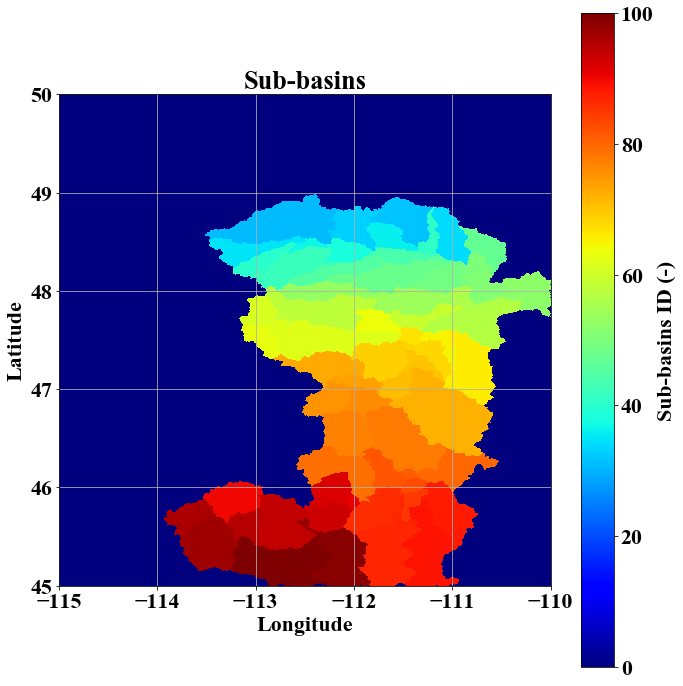

In [18]:
# creat a zero grid similar to the shape of the DEM
# read the bil or geotiff, the code reads the file and is in grid as declared name "dem"
grid = Grid.from_raster(path+'n45w115_con_bil/n45w115_con.bil', data_name='dem')
grid = Grid.from_raster(path+'dir.tif', data_name='dir')
# Specify directional mapping
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)


# initializing the sub_basin raster
z1 = np.zeros(grid.shape)
# loop over each segment of the river
for index, row in A.iterrows():
    cat_ID = A['ID'].iloc[index] # get the ID of that river segment
    #print(cat_ID)
    #print(A.iloc[index])
    #print('----------------------')
    # create subbasin of that river segment
    c_2 = grid.catchment(A['end_lon_b'].iloc[index], A['end_lat_b'].iloc[index], \
                       data='dir', dirmap=dirmap, xytype='label', inplace=False)
    c_2 = (c_2 != 0).astype(int)
    #print(c_2.max())
    #print('----------------------')
    if A['Up_ID'].iloc[index]=='[]': # in case no upstream, first order river segment
        #print('first order', A['Up_ID'].iloc[index])
        c_1 = np.zeros(grid.shape)  # no upstream area should be carved from the deliniated sub-basin
    else:
        #print('higher order', A['Up_ID'].iloc[index])
        c_1_temp = np.zeros(grid.shape)
        # find the index of the upstream area in the
        s=A['Up_ID'].iloc[index] # get the string of upstream id onjects
        # remove 
        s = s.replace('[', '')
        s = s.replace(']', '')
        up_ids = np.fromstring(s, dtype=int, sep=',')
        # loop over upstream segments and create the model
        for i in np.arange(up_ids.size):
            #print(up_ids[i])
            #find the index of the upstream and creat the basin
            index_local = A.index[A['ID'] == up_ids[i]].tolist()
            index_local = int(index_local[0]) # the local index of upstream segment
            c_1 = grid.catchment(A['end_lon_b'].iloc[index_local], A['end_lat_b'].iloc[index_local], \
                                 data='dir', dirmap=dirmap, xytype='label', inplace=False)
            c_1_temp = c_1_temp + (c_1 != 0).astype(int)
        c_1 = c_1_temp
    # carve the upstream area from the river segment
    c = c_2 - c_1
    #print(c.max())
    z1 += cat_ID * (c != 0).astype(int)

# Add z1 to grid
grid.add_gridded_data(z1, data_name='sub_basin', affine=grid.affine,
                      shape=grid.shape, crs=grid.crs, nodata=np.nan)

# Write to raster
grid.to_raster('sub_basin', path+'sub_basin.tif', view=False)

# show the deliniated sub-basin
plt.figure(figsize = (10,10))
plt.imshow(grid.sub_basin.astype(int), extent=grid.extent, cmap='jet')#, zorder=1)
plt.colorbar(label='Sub-basins ID (-)')
plt.grid(zorder=0)
plt.title('Sub-basins')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig(path+'Sub_basins.png', bbox_inches='tight') # save the figure

In [12]:
from osgeo import gdal, ogr
import sys
# this allows GDAL to throw Python Exceptions
#gdal.UseExceptions()
src_ds = gdal.Open( path+'sub_basin.tif' )
srcband = src_ds.GetRasterBand(1)
dst_layername = path+'sub_basin.shp'
drv = ogr.GetDriverByName('ESRI Shapefile')
dst_ds = drv.CreateDataSource(dst_layername)
dst_layer = dst_ds.CreateLayer(dst_layername , srs=None)
fd = ogr.FieldDefn('DN', ogr.OFTInteger)
dst_layer.CreateField(fd)
dst_field = dst_layer.GetLayerDefn().GetFieldIndex('DN')
gdal.Polygonize(srcband, None, dst_layer, dst_field, [], callback=None)

0